In [52]:
import json
import torch
import torch.nn as nn
from torch.utils.data import RandomSampler
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
import os
import time

from utils import load_im
from utils import save_im
from models.vae import VAE

batch_size = 16
learning_rate = 1e-3
data_path = 'data/obs'
intermediate_path = 'saved_models/vae/intermediate'
num_samples = 20000

model_name = 'conv_vae_obs'
resume_epoch = 0
num_epochs = resume_epoch + 200

torch.cuda.is_available()

True

In [53]:
def save_model_checkpoint(model, name, epoch):
    torch.save(model.state_dict(), f'{intermediate_path}/{name}_epoch{epoch}.pth')

def show_dataset_samples(dataset):
    w, h = 10, 10
    columns, rows = 4, 5
    fig = plt.figure(figsize=(8, 8))
    for i in range(1, columns*rows +1):
        im = np.reshape(dataset[np.random.randint(len(dataset))][0], (64, 64))
        fig.add_subplot(rows, columns, i)
        plt.imshow(im)
    plt.show()

def load_dataset(data_path, num_samples=5000, batch_size=64):
    print(f'Loading data from {data_path}...')
    train_dataset = datasets.ImageFolder(
        root=data_path,
        transform= transforms.Compose([
            transforms.Grayscale(), 
            transforms.RandomAffine(
                degrees=(-180.0, 180.0), 
                translate=(0.5, 0.5), 
                scale=(1.0, 4.0)),
            transforms.Resize((64, 64)), 
            transforms.ToTensor()
        ])
    )
    use_full = num_samples < 1
    num_samples = len(train_dataset) if use_full else num_samples
    sampler = RandomSampler(train_dataset) if use_full else RandomSampler(train_dataset, replacement=True, num_samples=num_samples)
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=0,
        sampler=sampler
    )
    train_dataset_size_full = len(train_dataset.samples)
    print(f'{train_dataset_size_full} samples found. Sampling {num_samples} for training.')

    return train_loader

def loss_function(recon_x, x, mu, logsigma):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')   # reconstruction loss
    KLD = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())       # KL divergence
    return BCE + KLD, BCE, KLD

def train(model, train_loader, num_epochs=5, learning_rate=1e-3):
    num_samples = len(train_loader.dataset)
    batch_size = train_loader.batch_size
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    outputs = []
    for epoch in range(resume_epoch, num_epochs):
        train_loss, bce_sum, kld_sum = 0, 0, 0
        for i, batch in enumerate(train_loader, 0):
            optimizer.zero_grad()
            x = batch[0].cuda()
            recon_batch, mu, logsigma = model(x)
            loss, bce, kld = loss_function(recon_batch, x, mu, logsigma)
            loss.backward()
            train_loss += loss.item()
            bce_sum += bce
            kld_sum += kld
            optimizer.step()

            # progress
            pct = (i*batch_size/num_samples)*100.0
            print('\r[ %.2f%% ]' % round(pct, 2), end='', flush=True)

        train_loss_mean = train_loss/float(num_samples)
        bce_mean = bce_sum/float(num_samples)
        kld_mean = kld_sum/float(num_samples)

        print('\nEpoch:{}, Loss:{:.4f}, BCE:{:.4f}, KLD:{:.4f}'.format(epoch+1, train_loss_mean, bce_mean, kld_mean))
        outputs.append((epoch, x, recon_batch),)

        # save checkpoint
        save_model_checkpoint(model, model_name, epoch)

    print('Finished!')
    save_model_checkpoint(model, model_name, epoch)
    return outputs

def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight, gain=1.0)
        m.bias.data.fill_(0.01)

Loading data from data/obs...
9730 samples found. Sampling 9730 for training.


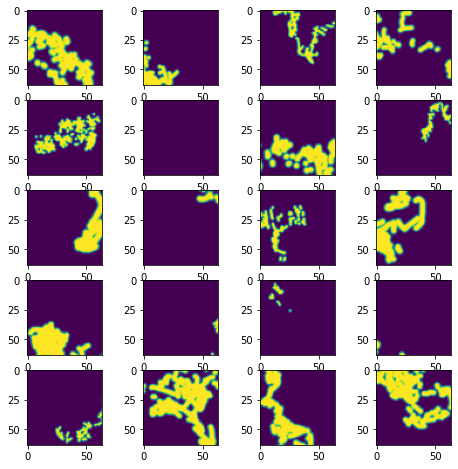

[ 99.98% ]
Epoch:1, Loss:1113.9666, BCE:1095.3514, KLD:18.6148
[ 99.98% ]
Epoch:2, Loss:778.8413, BCE:752.1052, KLD:26.7359
[ 99.98% ]
Epoch:3, Loss:729.3358, BCE:701.1254, KLD:28.2108
[ 99.98% ]
Epoch:4, Loss:691.8903, BCE:662.6441, KLD:29.2462
[ 99.98% ]
Epoch:5, Loss:672.3494, BCE:642.3326, KLD:30.0166
[ 99.98% ]
Epoch:6, Loss:652.4558, BCE:622.0278, KLD:30.4280
[ 99.98% ]
Epoch:7, Loss:635.3857, BCE:604.5217, KLD:30.8641
[ 99.98% ]
Epoch:8, Loss:634.4011, BCE:603.0295, KLD:31.3713
[ 99.98% ]
Epoch:9, Loss:623.1786, BCE:591.4137, KLD:31.7650
[ 99.98% ]
Epoch:10, Loss:617.8437, BCE:585.6188, KLD:32.2246
[ 99.98% ]
Epoch:11, Loss:602.8892, BCE:570.6523, KLD:32.2370
[ 99.98% ]
Epoch:12, Loss:605.7288, BCE:573.2761, KLD:32.4530
[ 99.98% ]
Epoch:13, Loss:600.1453, BCE:567.6224, KLD:32.5229
[ 99.98% ]
Epoch:14, Loss:594.8373, BCE:562.2114, KLD:32.6263
[ 99.98% ]
Epoch:15, Loss:597.4838, BCE:564.8249, KLD:32.6587
[ 99.98% ]
Epoch:16, Loss:593.0623, BCE:560.3264, KLD:32.7358
[ 99.98% ]
Epoc

In [3]:
# Training
with open('config/creature.json') as f:
    config = json.load(f)
    latent_size = config.get('vae.latent.size')

torch.manual_seed(1)
model = VAE(latent_size)

model_checkpoint_path = f'{intermediate_path}/{model_name}_epoch_{resume_epoch}.pth'
if (os.path.exists(model_checkpoint_path)):
    model.load_state_dict(torch.load(model_checkpoint_path))
else:
    model.apply(init_weights)

model.cuda()

train_loader = load_dataset(data_path, num_samples, batch_size)
show_dataset_samples(train_loader.dataset)

outputs = train(
    model=model, 
    train_loader=train_loader,
    num_epochs=num_epochs, 
    learning_rate=learning_rate
)

loss: 233.82786560058594
bce: 198.16940307617188
kld:35.6584587097168


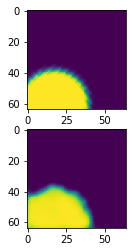

In [51]:
# Inference
with open('config/creature.json') as f:
    config = json.load(f)
    model_path = 'saved_models/vae/intermediate/conv_vae_obs_epoch199.pth'
    latent_size = config.get('vae.latent.size')

model = VAE(latent_size)
model.load_state_dict(torch.load(model_path))
model.cuda()
model.eval()

transform = transforms.Compose([
    transforms.Grayscale(), 
    transforms.RandomAffine(
        degrees=(-180.0, 180.0), 
        translate=(0.5, 0.5), 
        scale=(1.0, 4.0)),
    transforms.Resize((64, 64)), 
    transforms.ToTensor()
])

from PIL import Image
im_orig = Image.open('data/validate/test6.png')

im = transform(im_orig)
im = im.reshape((1,1,64,64)).cuda()

im_recon, mu, logsigma = model.cuda().forward(im)
loss, bce, kld = loss_function(im_recon, im, mu, logsigma)
print(f'loss: {loss}\nbce: {bce}\nkld:{kld}')

plot_im_out = np.reshape(im_recon.cpu().detach().numpy(), (64, 64))
plot_im = np.reshape(im.cpu().detach().numpy(), (64, 64))

fig, ax = plt.subplots(2, 1)
plt.subplot(211) 

plt.imshow(plot_im)
plt.subplot(212)
plt.imshow(plot_im_out)
plt.savefig(f'data/validate/out/{time.time()}.png')